## MNIST

Reference: 

### Import functions and MNIST dataset

In [3]:
import sklearn
from sklearn.datasets import fetch_openml

In [4]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

### Prepare data

In [125]:
X, y = mnist["data"], mnist["target"]
X.shape
y.shape
print("Shape of X:", X.shape,"\nShape of y:", y.shape)

Shape of X: (70000, 784) 
Shape of y: (70000,)


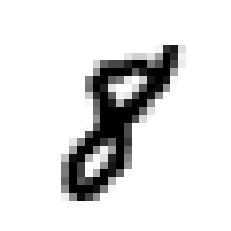

In [131]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[17] # getting data from index 17
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [31]:
# Define target on index 17
y[17]

8

In [25]:
import numpy as np
y = y.astype(np.uint8)

In [26]:
# Split dataset into 60,000 training set and 10,000 test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In [27]:
# Creat target vectors for training set and test set

y_train_8 = (y_train == 8)  # True for all 8s, False for all other digits
y_test_8 = (y_test == 8)

In [35]:
# Predict using Stochastic Gradient Descent (SGD) classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_8)
sgd_clf.predict([some_digit])

array([ True])

In [140]:
# Measuring Accuracy Using Cross-Validation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_8):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_8[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_8[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))  

0.9365
0.92665
0.8386


In [34]:
# Evaluate accuracy using k-fold cross validation
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_8, cv=3, scoring="accuracy")

array([0.909  , 0.9286 , 0.88285])

In [38]:
# Re-evaulate to check the accuracy of images thaat are not 8
from sklearn.base import BaseEstimator

class Never8Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_8_clf = Never8Classifier()
cross_val_score(never_8_clf, X_train, y_train_8, cv=3, scoring="accuracy")

array([0.9039 , 0.9031 , 0.90045])

In [40]:
# Predict training set using cross validation
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_8, cv=3)

array([[50006,  4143],
       [ 1448,  4403]], dtype=int64)

In [47]:
# Predict training set using confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_8, y_train_pred)

array([[50006,  4143],
       [ 1448,  4403]], dtype=int64)

In [41]:
y_train_perfect_predictions = y_train_8  # pretend we reached perfection
confusion_matrix(y_train_8, y_train_perfect_predictions)

array([[54149,     0],
       [    0,  5851]], dtype=int64)

In [48]:
# Define presicion score (True Positive/ True Positive + False Positive )

from sklearn.metrics import precision_score, recall_score

precision_score(y_train_8, y_train_pred) #== 4403 / (4403 + 4143)

0.515211794991809

In [49]:
# Define Recall score (True Positive/ True Positive + False Negative )
recall_score(y_train_8, y_train_pred) # == 44032 / (4403 + 1448)

0.7525209365920356

In [53]:
# Define f1 score
from sklearn.metrics import f1_score
f1_score(y_train_8, y_train_pred)

0.611655205945683

In [81]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_8, cv=3,
                             method="decision_function")

In [82]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_8, y_scores)

In [96]:
# Assume some threshold
threshold = 1000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False, False, False, ..., False, False,  True])

In [97]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_8, y_scores)

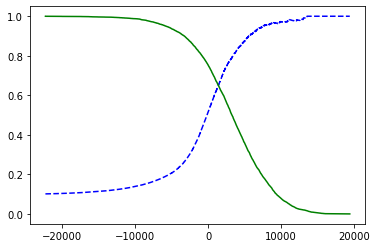

In [98]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    [...] # highlight the threshold and add the legend, axis label, and grid

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [103]:
# Define valus of thershold that has precison over 90%
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print("Threshold at",threshold_90_precision, "will have a precision equal or greater than 90%")

Threshold at 5558.6889510792735 will have a precision equal or greater than 90%


In [100]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ..., False, False, False])

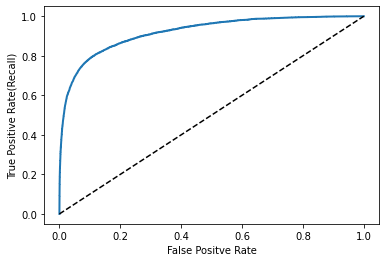

In [108]:
# Plot the False Positive Rat(FPR) against the True Positive Rate(TPR)
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_8, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    [...] # Add axis labels and grid

plot_roc_curve(fpr, tpr)
plt.xlabel("False Positve Rate")
plt.ylabel("True Positive Rate(Recall)")
plt.show()

In [109]:
# Define score of Area Under the Receiver Operating Characteristic Curve (ROC AUC)
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_8, y_scores)

0.9192599874103056

## Train dataset using Random Forest Classifier

In [110]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_8, cv=3,
                                    method="predict_proba")

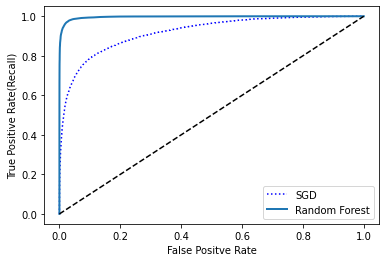

In [113]:
# Define score for positive class’s probability and plot ROC curve to compare SGD and 
y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_8,y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.xlabel("False Positve Rate")
plt.ylabel("True Positive Rate(Recall)")
plt.show()

The above graph shows that he Random Forest classifier is superior to the SGD classifier because its ROC curve is much closer to the top-left corner, and it has a greater AUC

In [114]:
roc_auc_score(y_train_8, y_scores_forest)

0.9965481456893603

## Train dataset using Extra Forest Classifier

In [142]:
from sklearn.ensemble import ExtraTreeClassifier

extraForest_clf = RandomForestClassifier(random_state=42)
y_probas_extraForest = cross_val_predict(extraForest_clf, X_train, y_train_8, cv=3,
                                    method="predict_proba")



ImportError: cannot import name 'ExtraTreeClassifier' from 'sklearn.ensemble' (C:\Users\poope\anaconda3\lib\site-packages\sklearn\ensemble\__init__.py)

In [ ]:
y_scores_extraForest = y_probas_extraForest[:, 1]   
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_8,y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.xlabel("False Positve Rate")
plt.ylabel("True Positive Rate(Recall)")
plt.show()